In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install numpy
!git clone https://github.com/theaboy/linear-regression-bike-demand.git

fatal: destination path 'linear-regression-bike-demand' already exists and is not an empty directory.


#Import Data and Clean Up

In [ ]:
df = pd.read_csv("linear-regression-bike-demand/day.csv")
display(df.head())
df.shape
df.info()
n_rows, n_columns = np.shape(df)
print(f"# Instances / data points/ rows / tuples (rows): {n_rows}")
print(f"# Columns / features / attributes: {n_columns}")

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
# Instances / data points/ rows / tuples (rows): 731
# Columns / features / attributes: 16


In [ ]:
# ===============================
# Data validation & outlier capping
# ===============================

df = df.copy()

# 1) Parse date safely
df["dteday"] = pd.to_datetime(df["dteday"], errors="coerce")

# 2) Define validation rules
rules = {
    "instant":      ("int",   (1, None)),
    "season":       ("cat",   {1,2,3,4}),
    "yr":           ("cat",   {0,1}),
    "mnth":         ("int",   (1,12)),
    "holiday":      ("cat",   {0,1}),
    "weekday":      ("cat",   {0,1,2,3,4,5,6}),
    "workingday":   ("cat",   {0,1}),
    "weathersit":   ("cat",   {1,2,3,4}),
    "temp":         ("float", (0,1)),
    "atemp":        ("float", (0,1)),
    "hum":          ("float", (0,1)),
    "windspeed":    ("float", (0,1)),
    "casual":       ("int",   (0, None)),
    "registered":   ("int",   (0, None)),
    "cnt":          ("int",   (0, None)),
}

# 3) Run validation checks
malformed_report = {}

for col, (kind, rule) in rules.items():
    if col not in df.columns:
        continue

    s = df[col]

    # Coerce numeric types
    if kind in ["int", "float"] and s.dtype == "object":
        df[col] = pd.to_numeric(s, errors="coerce")
        s = df[col]

    if kind == "cat":
        bad = ~s.isin(rule) & s.notna()
        malformed_report[col] = int(bad.sum())

    else:  # numeric
        lo, hi = rule
        bad = pd.Series(False, index=df.index)
        if lo is not None:
            bad |= (s < lo)
        if hi is not None:
            bad |= (s > hi)
        bad &= s.notna()
        malformed_report[col] = int(bad.sum())

print("\n=== MALFORMED VALUE SUMMARY ===")
print(pd.Series(malformed_report).sort_values(ascending=False))

# 4) Date checks
bad_dates = df["dteday"].isna().sum()
dup_days = df["dteday"].duplicated().sum()

print(f"\nBad / unparseable dates: {bad_dates}")
print(f"Duplicate dates: {dup_days}")

# 5) IQR outlier detection
num_cols = df.select_dtypes(include=[np.number]).columns
outlier_report = {}

for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    outlier_report[col] = ((df[col] < low) | (df[col] > high)).sum()

print("\n=== OUTLIER COUNTS (IQR rule) ===")
print(pd.Series(outlier_report).sort_values(ascending=False))

# 6) Cap continuous features
continuous_cols = ["temp", "atemp", "hum", "windspeed"]

for col in continuous_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    df[col] = df[col].clip(low, high) #bring to bounds

print("\n Outliers capped for:", continuous_cols)



=== MALFORMED VALUE SUMMARY ===
instant       0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Bad / unparseable dates: 0
Duplicate dates: 0

=== OUTLIER COUNTS (IQR rule) ===
casual        44
holiday       21
windspeed     13
hum            2
yr             0
season         0
instant        0
workingday     0
weekday        0
mnth           0
weathersit     0
atemp          0
temp           0
registered     0
cnt            0
dtype: int64

 Outliers capped for: ['temp', 'atemp', 'hum', 'windspeed']


#Continuous Feature Exploration

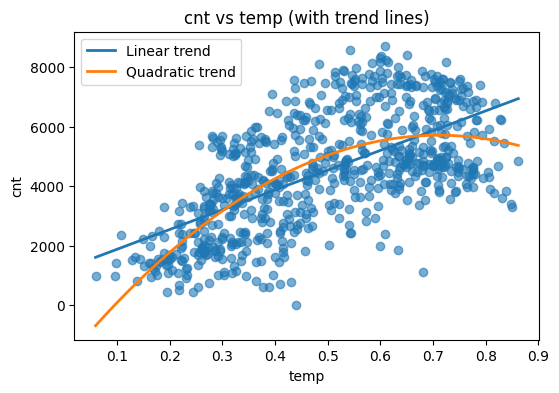

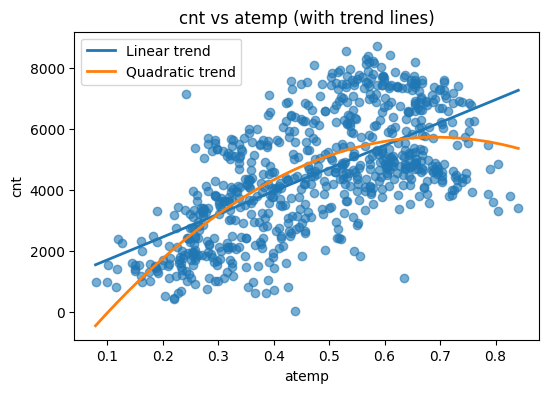

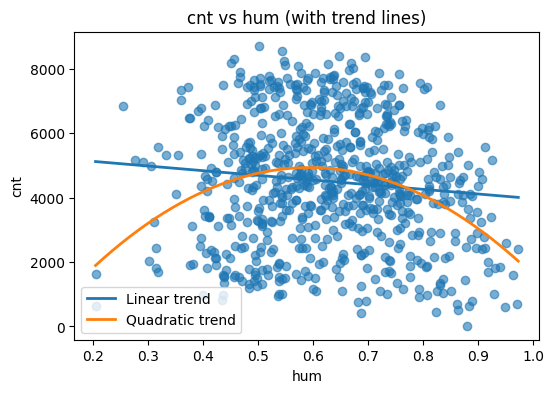

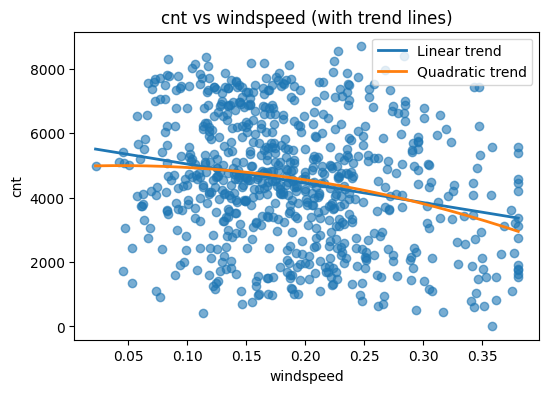

In [ ]:
features_to_check = ["temp", "atemp", "hum", "windspeed"]

for col in features_to_check:
    plt.figure(figsize=(6,4))
    plt.scatter(df[col], df["cnt"], alpha=0.6)

    # ---- Trend line (linear) ----
    x = df[col].values
    y = df["cnt"].values

    z1 = np.polyfit(x, y, 1)          # degree 1
    p1 = np.poly1d(z1)

    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, p1(xs), linewidth=2, label="Linear trend")

    # ---- Trend line (quadratic) ----
    z2 = np.polyfit(x, y, 2)          # degree 2
    p2 = np.poly1d(z2)

    plt.plot(xs, p2(xs), linewidth=2, label="Quadratic trend")

    plt.title(f"cnt vs {col} (with trend lines)")
    plt.xlabel(col)
    plt.ylabel("cnt")
    plt.legend()
    plt.show()

#Discrete Feature Exploration

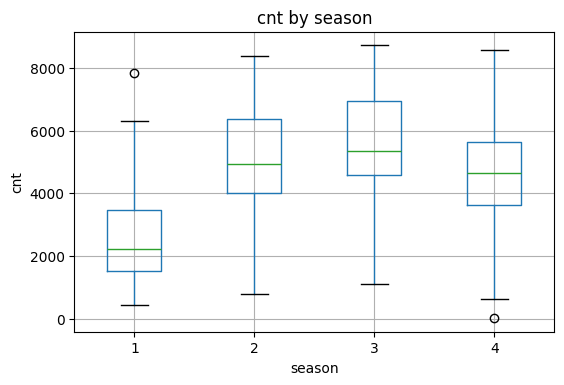

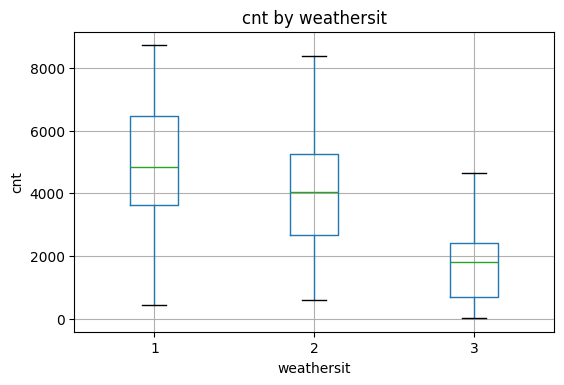

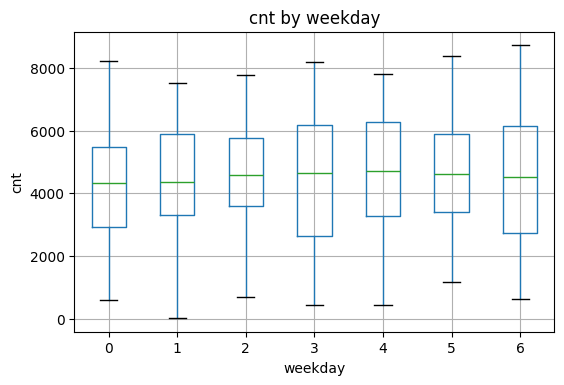

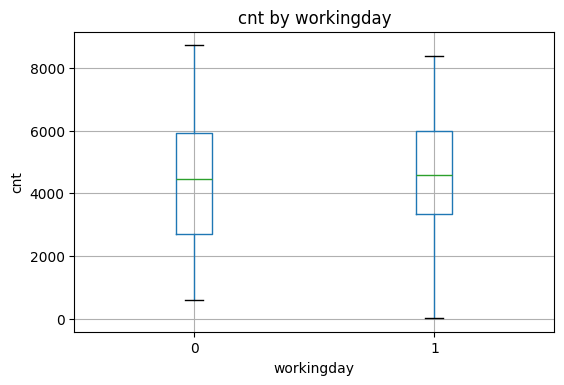

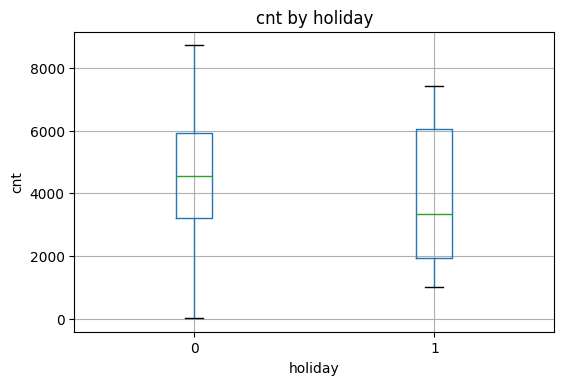

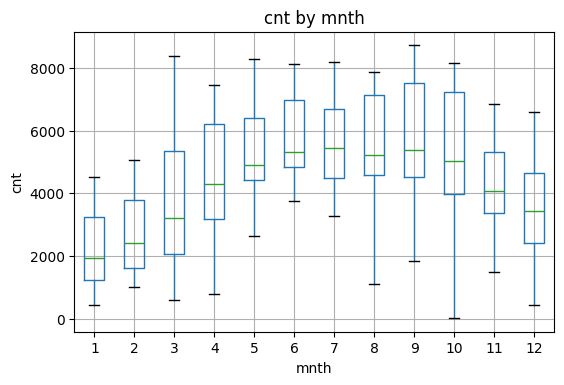

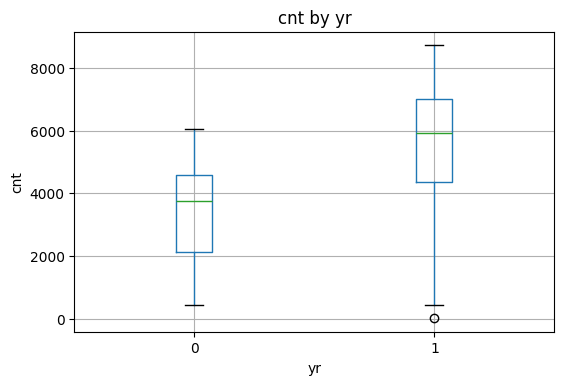

In [ ]:
cat_cols = ["season", "weathersit", "weekday", "workingday", "holiday", "mnth", "yr"]

for col in cat_cols:
    df.boxplot(column="cnt", by=col, figsize=(6,4))
    plt.title(f"cnt by {col}")
    plt.suptitle("")  # removes automatic pandas title
    plt.xlabel(col)
    plt.ylabel("cnt")
    plt.show()

#Preparing Design and Target Tables

In [ ]:
columns_to_drop = ['instant', 'casual', 'registered', 'holiday', 'cnt','dteday']
df_design = df.drop(columns=columns_to_drop)
df_cnt = df[['cnt']]

print(f'Columns removed: {columns_to_drop}')
print('\nDataFrame after dropping columns:')
display(df_design.head())
display(df_cnt.head())

print(df_design.info())
print(df_cnt.info())

Columns removed: ['instant', 'casual', 'registered', 'holiday', 'cnt', 'dteday']

DataFrame after dropping columns:


,season,yr,mnth,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,0,1,6,0,2,0.344167,0.363625,0.805833,0.160446
1,1,0,1,0,0,2,0.363478,0.353739,0.696087,0.248539
2,1,0,1,1,1,1,0.196364,0.189405,0.437273,0.248309
3,1,0,1,2,1,1,0.200000,0.212122,0.590435,0.160296
4,1,0,1,3,1,1,0.226957,0.229270,0.436957,0.186900


,cnt
0,985
1,801
2,1349
3,1562
4,1600


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   weekday     731 non-null    int64  
 4   workingday  731 non-null    int64  
 5   weathersit  731 non-null    int64  
 6   temp        731 non-null    float64
 7   atemp       731 non-null    float64
 8   hum         731 non-null    float64
 9   windspeed   731 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 57.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cnt     731 non-null    int64
dtypes: int64(1)
memory usage: 5.8 KB
None


In [ ]:
categorical_cols = ["season", "weathersit", "weekday", "mnth"]

df_design = pd.get_dummies(
    df_design,
    columns = categorical_cols,  # avoids dummy variable trap
)
df_design = df_design.apply(pd.to_numeric, errors="raise")

design = df_design.to_numpy(dtype=np.float64)
feature_columns = list(df_design.columns)

#add y-intercept to the design matrix

design = np.column_stack((np.ones(design.shape[0]), design))
cnt = df_cnt.to_numpy()
print(df_design.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            731 non-null    int64  
 1   workingday    731 non-null    int64  
 2   temp          731 non-null    float64
 3   atemp         731 non-null    float64
 4   hum           731 non-null    float64
 5   windspeed     731 non-null    float64
 6   season_1      731 non-null    bool   
 7   season_2      731 non-null    bool   
 8   season_3      731 non-null    bool   
 9   season_4      731 non-null    bool   
 10  weathersit_1  731 non-null    bool   
 11  weathersit_2  731 non-null    bool   
 12  weathersit_3  731 non-null    bool   
 13  weekday_0     731 non-null    bool   
 14  weekday_1     731 non-null    bool   
 15  weekday_2     731 non-null    bool   
 16  weekday_3     731 non-null    bool   
 17  weekday_4     731 non-null    bool   
 18  weekday_5     731 non-null    

#Seperating Data into Test and Trainning Sets

In [ ]:
np.random.seed(42)

n = design.shape[0]
indices = np.random.permutation(n)

train_size = int(0.8 * n)
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train = design[train_idx]
y_train = cnt[train_idx]

X_test = design[test_idx]
y_test = cnt[test_idx]
# ---- NORMALIZATION (from scratch) ----

# Copy to avoid modifying original arrays
X_train_norm = X_train.copy()
X_test_norm  = X_test.copy()

# Compute mean and std from TRAINING data ONLY (excluding bias column)
mean = X_train_norm[:, 1:].mean(axis=0)
std  = X_train_norm[:, 1:].std(axis=0)

# Avoid division by zero
std[std == 0] = 1

# Normalize (exclude bias column at index 0)
X_train_norm[:, 1:] = (X_train_norm[:, 1:] - mean) / std
X_test_norm[:, 1:]  = (X_test_norm[:, 1:]  - mean) / std




Beta = np.linalg.lstsq(X_train_norm, y_train, rcond=None)[0]
# w, residuals, rank, singular_values

display(Beta)

array([[ 4.49659932e+03],
       [ 9.88031396e+02],
       [ 2.56025823e+02],
       [ 6.49783873e+02],
       [ 2.00866057e+02],
       [-2.31414721e+02],
       [-2.44388124e+02],
       [-3.16365421e+02],
       [ 3.56131490e+01],
       [-3.76848338e+01],
       [ 3.16104144e+02],
       [ 1.48880931e+02],
       [-4.86765020e+01],
       [-2.88782143e+02],
       [ 2.00957140e+01],
       [-1.06865868e+02],
       [-4.87154324e+01],
       [-3.74168631e+00],
       [-2.97129091e+01],
       [-6.50293188e+00],
       [ 1.87572660e+02],
       [-8.34893312e+01],
       [-9.28492638e+01],
       [ 4.89028027e+01],
       [ 8.70722714e+00],
       [ 7.78087003e+01],
       [ 5.34910362e+01],
       [-5.77933791e+01],
       [ 3.31145622e+01],
       [ 1.87877622e+02],
       [ 5.13082965e+01],
       [-1.11391236e+02],
       [-1.19869036e+02]])

#Linear Regression

In [ ]:
y_train_pred = X_train_norm @ Beta
y_test_pred = X_test_norm @ Beta

#Calculate Mean Squared Error

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

train_mse = mse(y_train, y_train_pred)
test_mse = mse(y_test, y_test_pred)

print("Training MSE:", train_mse)
print("Test MSE:", test_mse)

Training MSE: 584924.1316831177
Test MSE: 535193.285102313


#Results Visualization

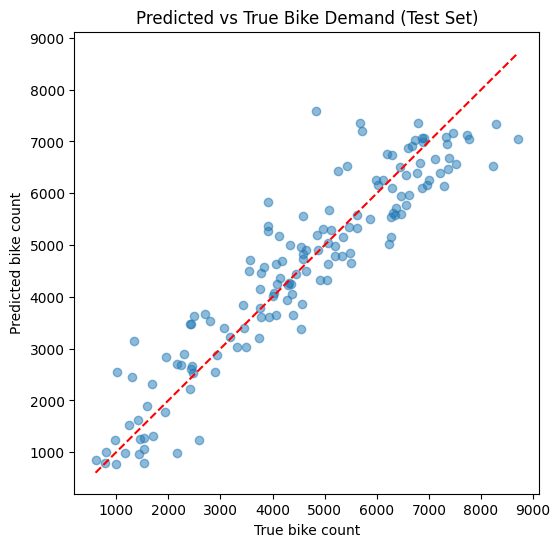

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--",
    color="red"
)
plt.xlabel("True bike count")
plt.ylabel("Predicted bike count")
plt.title("Predicted vs True Bike Demand (Test Set)")
plt.show()

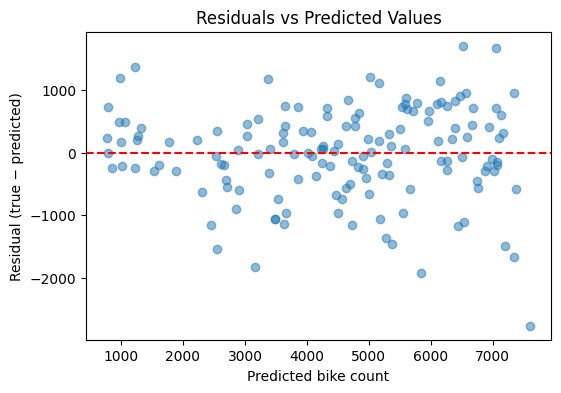

In [ ]:
residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted bike count")
plt.ylabel("Residual (true − predicted)")
plt.title("Residuals vs Predicted Values")
plt.show()

# Most influencal features

In [ ]:
# ===============================
# Standardize continuous features
# ===============================

feature_names = ["intercept"] + list(df_design.columns)

continuous_cols = ["temp", "atemp", "hum", "windspeed"]
continuous_idx = [feature_names.index(col) for col in continuous_cols]

X_train_std = X_train.copy()
X_test_std = X_test.copy()

mean = X_train[:, continuous_idx].mean(axis=0)
std = X_train[:, continuous_idx].std(axis=0)
std[std == 0] = 1

X_train_std[:, continuous_idx] = (X_train[:, continuous_idx] - mean) / std
X_test_std[:, continuous_idx]  = (X_test[:, continuous_idx]  - mean) / std

In [ ]:
# ==========================
# Most influencal features
# =========================
print("y_train mean:", float(y_train.mean()))
print("y_train std :", float(y_train.std()))
Beta_std = np.linalg.lstsq(X_train_std, y_train, rcond=None)[0]
coef_table = pd.DataFrame({
    "feature": feature_names,
    "beta": Beta_std.flatten(),
    "abs_beta": np.abs(Beta_std.flatten())
}).sort_values("abs_beta", ascending=False)

coef_table_no_intercept = coef_table[coef_table.feature != "intercept"]
display(coef_table_no_intercept)



y_train mean: 4496.5993150684935
y_train std : 1924.8981507657616


,feature,beta,abs_beta
1,yr,1976.248224,1976.248224
11,weathersit_1,1277.059155,1277.059155
10,season_4,1073.556026,1073.556026
12,weathersit_2,863.330866,863.330866
29,mnth_9,802.519942,802.519942
20,weekday_6,758.828487,758.828487
13,weathersit_3,-750.965664,750.965664
3,temp,649.783873,649.783873
2,workingday,560.728533,560.728533
8,season_2,433.249644,433.249644


In [ ]:
# ============================================
# Train a model using ONLY the most influential features
# ============================================

# Choose how many top features you want (change this) ps : to run you should RUN ALL not individually run
top_k = 10


coef_table_no_intercept = coef_table[coef_table["feature"] != "intercept"].copy()

top_features = (
    coef_table_no_intercept
    .sort_values("abs_beta", ascending=False)
    .head(top_k)["feature"]
    .tolist()
)

print("Top features:", top_features)


feature_names = ["intercept"] + list(df_design.columns)

top_idx = [feature_names.index(f) for f in top_features]


X_train_top = X_train_std[:, [0] + top_idx]
X_test_top  = X_test_std[:,  [0] + top_idx]


Beta_top = np.linalg.lstsq(X_train_top, y_train, rcond=None)[0]


y_pred_train = X_train_top @ Beta_top
y_pred_test  = X_test_top  @ Beta_top


mse_train = np.mean((y_train - y_pred_train) ** 2)
mse_test  = np.mean((y_test  - y_pred_test)  ** 2)



print(f"Train MSE: {float(mse_train):.2f}")
print(f"Test  MSE: {float(mse_test):.2f}")


coef_top = pd.DataFrame({
    "feature": ["intercept"] + top_features,
    "beta": Beta_top.flatten(),
    "abs_beta": np.abs(Beta_top.flatten())
}).sort_values("abs_beta", ascending=False)

display(coef_top)

Top features: ['yr', 'weathersit_1', 'season_4', 'weathersit_2', 'mnth_9', 'weekday_6', 'weathersit_3', 'temp', 'workingday', 'season_2']
Train MSE: 703578.36
Test  MSE: 649394.58


,feature,beta,abs_beta
1,yr,1993.722539,1993.722539
2,weathersit_1,1515.908413,1515.908413
0,intercept,1343.917914,1343.917914
3,season_4,1216.811633,1216.811633
8,temp,1146.413119,1146.413119
7,weathersit_3,-1057.037677,1057.037677
4,weathersit_2,885.047178,885.047178
5,mnth_9,803.495787,803.495787
10,season_2,635.744974,635.744974
6,weekday_6,604.906210,604.906210


#Feature Engineering

In [ ]:
def add_polynomial_features(X, degree=2):
    X_poly = X.copy()
    for d in range(2, degree + 1):
        X_poly = np.hstack((X_poly, X ** d))
    return X_poly

def add_interaction_terms(X):
    n_samples, n_features = X.shape
    interactions = []
    for i in range(n_features):
        for j in range(i + 1, n_features):
            interactions.append((X[:, i] * X[:, j]).reshape(-1, 1))
    return np.hstack([X] + interactions)

X_train_base = X_train_norm[:, 1:]
X_test_base  = X_test_norm[:, 1:]

X_train_fe = add_interaction_terms(add_polynomial_features(X_train_base, 2))
X_test_fe  = add_interaction_terms(add_polynomial_features(X_test_base, 2))


mean = X_train_fe.mean(axis=0)
std = X_train_fe.std(axis=0) + 1e-8

X_train_fe = (X_train_fe - mean) / std
X_test_fe  = (X_test_fe - mean) / std

X_train_fe = np.hstack([np.ones((X_train_fe.shape[0], 1)), X_train_fe])
X_test_fe  = np.hstack([np.ones((X_test_fe.shape[0], 1)), X_test_fe])

theta = np.linalg.pinv(X_train_fe.T @ X_train_fe) @ X_train_fe.T @ y_train


y_pred_train = X_train_fe @ theta
y_pred_test  = X_test_fe @ theta

mse_train = np.mean((y_train - y_pred_train) ** 2)
mse_test  = np.mean((y_test - y_pred_test) ** 2)

print("Train MSE:", mse_train)
print("Test MSE:", mse_test)

Train MSE: 86815.52955150155
Test MSE: 2288181.980186854


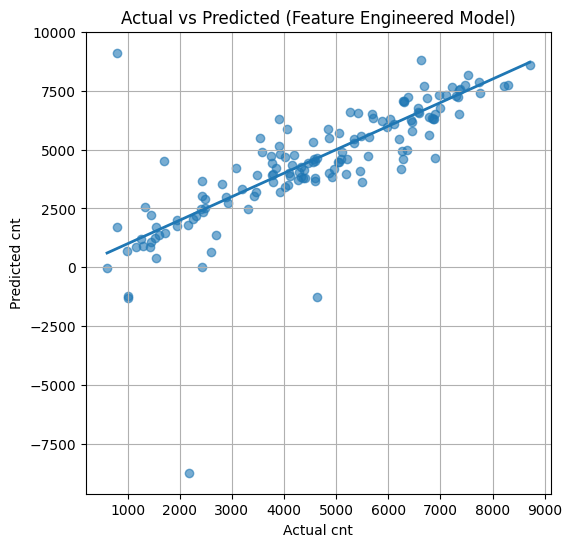

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linewidth=2)
plt.xlabel("Actual cnt")
plt.ylabel("Predicted cnt")
plt.title("Actual vs Predicted (Feature Engineered Model)")
plt.grid(True)
plt.show()


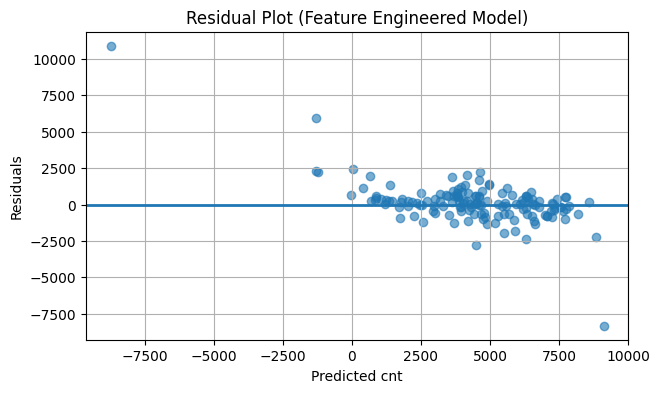

In [ ]:
residuals = y_test - y_pred_test

plt.figure(figsize=(7,4))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(0, linewidth=2)
plt.xlabel("Predicted cnt")
plt.ylabel("Residuals")
plt.title("Residual Plot (Feature Engineered Model)")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

# indices of features
temp_idx  = feature_columns.index("temp")
atemp_idx = feature_columns.index("atemp")
hum_idx   = feature_columns.index("hum")
wind_idx  = feature_columns.index("windspeed")

# ---- FEATURE ENGINEERING ON SCALED DATA ----
X_train_fe = np.column_stack([
    X_train,                                # scaled original features
    X_train[:, temp_idx]**2,                # temp^2
    X_train[:, atemp_idx]**2,               # atemp^2
    X_train[:, wind_idx]**2,                # windspeed^2
    X_train[:, temp_idx] * X_train[:, hum_idx]  # temp × hum
])

X_test_fe = np.column_stack([
    X_test,
    X_test[:, temp_idx]**2,
    X_test[:, atemp_idx]**2,
    X_test[:, wind_idx]**2,
    X_test[:, temp_idx] * X_test[:, hum_idx]
])

# ---- ADD BIAS (ONCE) ----
X_train_fe = np.c_[np.ones(X_train_fe.shape[0]), X_train_fe]
X_test_fe  = np.c_[np.ones(X_test_fe.shape[0]),  X_test_fe]

# ---- TRAIN LINEAR REGRESSION ----
theta = np.linalg.pinv(X_train_fe.T @ X_train_fe) @ (X_train_fe.T @ y_train)

# ---- PREDICT ----
y_pred_train = X_train_fe @ theta
y_pred_test  = X_test_fe @ theta

# ---- EVALUATE ----
mse_train = np.mean((y_train - y_pred_train)**2)
mse_test  = np.mean((y_test - y_pred_test)**2)

print("Train MSE:", mse_train)
print("Test  MSE:", mse_test)

Train MSE: 482685.99186911975
Test  MSE: 453286.14306283137


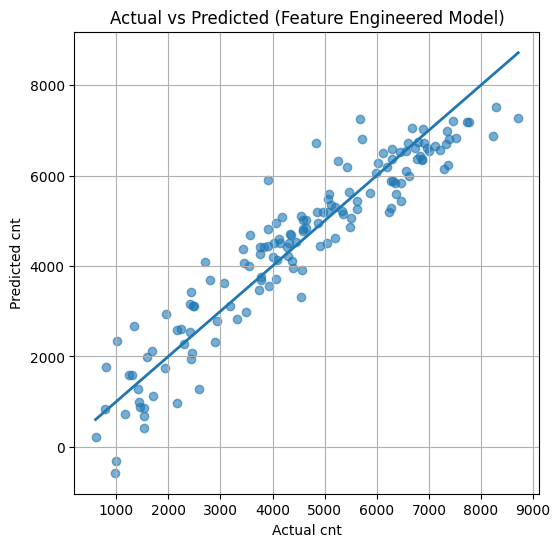

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linewidth=2)
plt.xlabel("Actual cnt")
plt.ylabel("Predicted cnt")
plt.title("Actual vs Predicted (Feature Engineered Model)")
plt.grid(True)
plt.show()

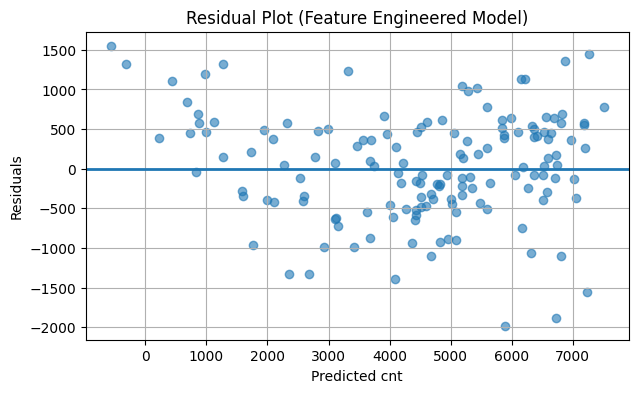

In [ ]:
residuals = y_test - y_pred_test

plt.figure(figsize=(7,4))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(0, linewidth=2)
plt.xlabel("Predicted cnt")
plt.ylabel("Residuals")
plt.title("Residual Plot (Feature Engineered Model)")
plt.grid(True)
plt.show()

#Perform Same Linear Regression Process for Casual vs Registered Bike Rental Ratio

In [ ]:
# ===============================
# Data validation & outlier capping
# ===============================

df = df.copy()

# 1) Parse date safely
df["dteday"] = pd.to_datetime(df["dteday"], errors="coerce")

# Create the new target variable 'casual_registered_ratio'
df['casual_registered_ratio'] = df['casual'] / (df['registered'])
# df'casual_registered_ratio' as the target variable
df_ratio = df[['casual_registered_ratio']]

# 2) Define validation rules
rules = {
    "instant":      ("int",   (1, None)),
    "season":       ("cat",   {1,2,3,4}),
    "yr":           ("cat",   {0,1}),
    "mnth":         ("int",   (1,12)),
    "holiday":      ("cat",   {0,1}),
    "weekday":      ("cat",   {0,1,2,3,4,5,6}),
    "workingday":   ("cat",   {0,1}),
    "weathersit":   ("cat",   {1,2,3,4}),
    "temp":         ("float", (0,1)),
    "atemp":        ("float", (0,1)),
    "hum":          ("float", (0,1)),
    "windspeed":    ("float", (0,1)),
    "casual":       ("int",   (0, None)),
    "registered":   ("int",   (0, None)),
    "cnt":          ("int",   (0, None)),
    "casual_registered_ratio": ("float", (0, None))
    }

# 3) Run validation checks
malformed_report = {}

for col, (kind, rule) in rules.items():
    if col not in df.columns:
        continue

    s = df[col]

    # Coerce numeric types
    if kind in ["int", "float"] and s.dtype == "object":
        df[col] = pd.to_numeric(s, errors="coerce")
        s = df[col]

    if kind == "cat":
        bad = ~s.isin(rule) & s.notna()
        malformed_report[col] = int(bad.sum())

    else:  # numeric
        lo, hi = rule
        bad = pd.Series(False, index=df.index)
        if lo is not None:
            bad |= (s < lo)
        if hi is not None:
            bad |= (s > hi)
        bad &= s.notna()
        malformed_report[col] = int(bad.sum())

print("\n=== MALFORMED VALUE SUMMARY ===")
print(pd.Series(malformed_report).sort_values(ascending=False))

# 4) Date checks
bad_dates = df["dteday"].isna().sum()
dup_days = df["dteday"].duplicated().sum()

print(f"\nBad / unparseable dates: {bad_dates}")
print(f"Duplicate dates: {dup_days}")

# 5) IQR outlier detection
num_cols = df.select_dtypes(include=[np.number]).columns
outlier_report = {}

for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    outlier_report[col] = ((df[col] < low) | (df[col] > high)).sum()

print("\n=== OUTLIER COUNTS (IQR rule) ===")
print(pd.Series(outlier_report).sort_values(ascending=False))

# 6) Cap continuous features
continuous_cols = ["temp", "atemp", "hum", "windspeed"]

for col in continuous_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    df[col] = df[col].clip(low, high) #bring to bounds

print("\n Outliers capped for:", continuous_cols)


=== MALFORMED VALUE SUMMARY ===
instant                    0
season                     0
yr                         0
mnth                       0
holiday                    0
weekday                    0
workingday                 0
weathersit                 0
temp                       0
atemp                      0
hum                        0
windspeed                  0
casual                     0
registered                 0
cnt                        0
casual_registered_ratio    0
dtype: int64

Bad / unparseable dates: 0
Duplicate dates: 0

=== OUTLIER COUNTS (IQR rule) ===
casual_registered_ratio    90
casual                     44
holiday                    21
instant                     0
mnth                        0
weekday                     0
yr                          0
season                      0
weathersit                  0
workingday                  0
temp                        0
atemp                       0
windspeed                   0
hum               

#Continuous Feature Exploration

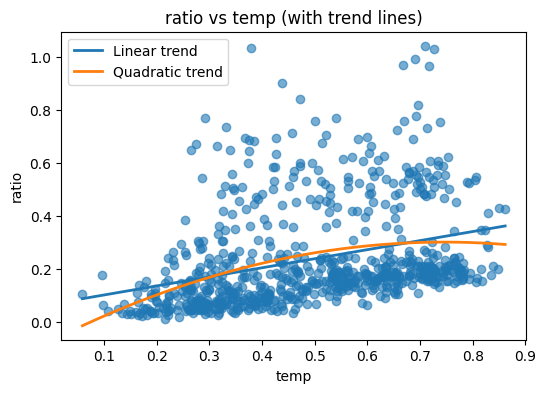

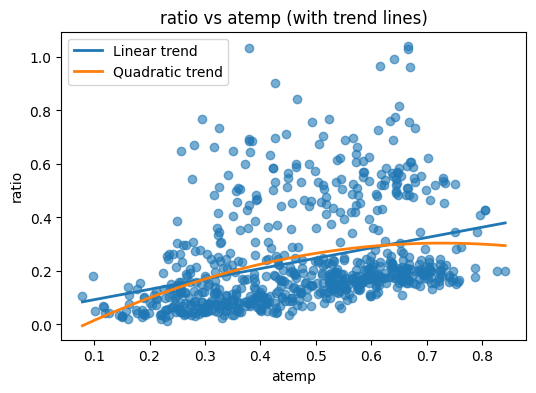

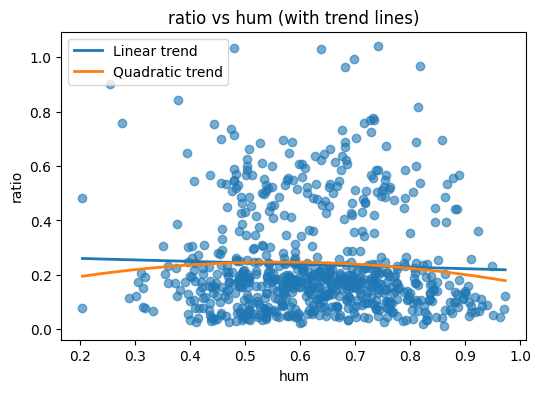

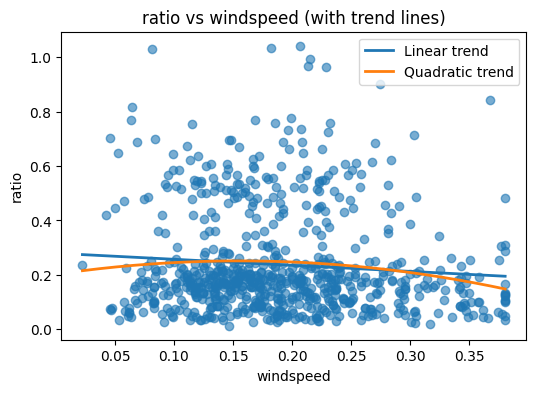

In [ ]:
features_to_check = ["temp", "atemp", "hum", "windspeed"]

for col in features_to_check:
    plt.figure(figsize=(6,4))
    plt.scatter(df[col], df_ratio["casual_registered_ratio"], alpha=0.6)

    # ---- Trend line (linear) ----
    x = df[col].values
    y = df["casual_registered_ratio"].values

    z1 = np.polyfit(x, y, 1)          # degree 1
    p1 = np.poly1d(z1)

    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, p1(xs), linewidth=2, label="Linear trend")

    # ---- Trend line (quadratic) ----
    z2 = np.polyfit(x, y, 2)          # degree 2
    p2 = np.poly1d(z2)

    plt.plot(xs, p2(xs), linewidth=2, label="Quadratic trend")

    plt.title(f"ratio vs {col} (with trend lines)")
    plt.xlabel(col)
    plt.ylabel("ratio")
    plt.legend()
    plt.show()

#Discrete Feature Exploration

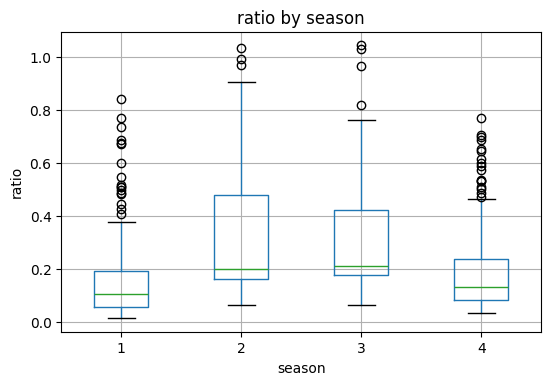

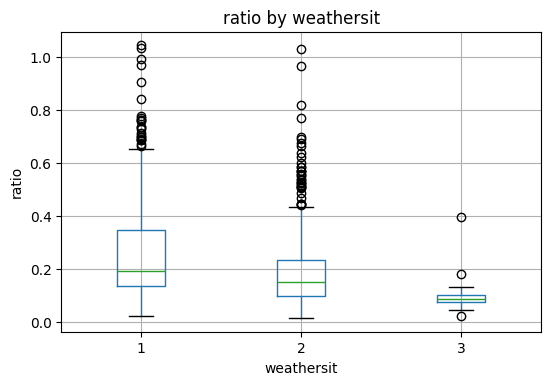

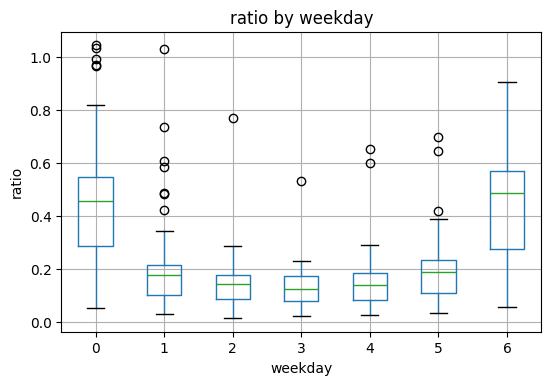

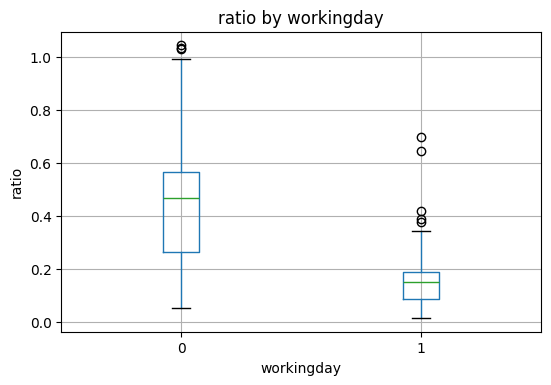

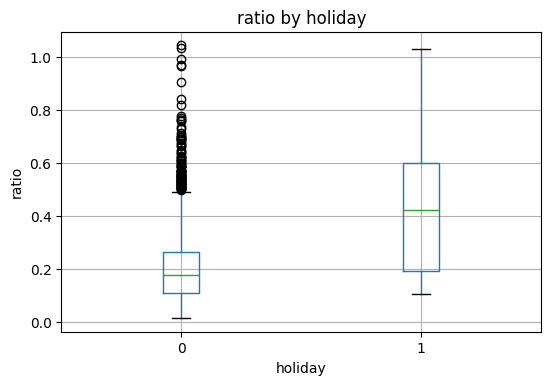

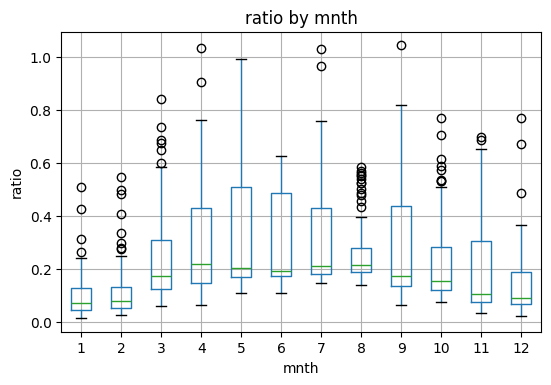

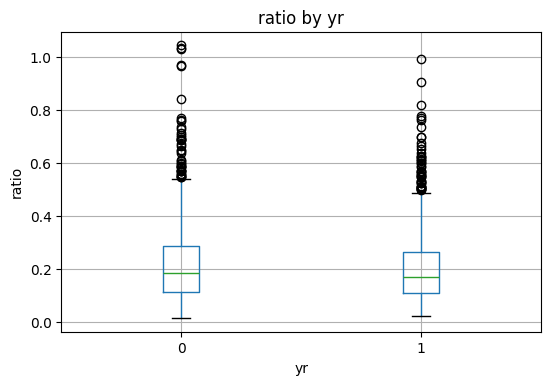

In [ ]:
cat_cols = ["season", "weathersit", "weekday", "workingday", "holiday", "mnth", "yr"]

for col in cat_cols:
    df.boxplot(column="casual_registered_ratio", by=col, figsize=(6,4))
    plt.title(f"ratio by {col}")
    plt.suptitle("")  # removes automatic pandas title
    plt.xlabel(col)
    plt.ylabel("ratio")
    plt.show()

#Prepare Design and Target Tables

In [ ]:
columns_to_drop = ['instant', 'casual', 'registered', 'holiday', 'yr', 'weathersit', 'season', 'cnt','dteday', 'casual_registered_ratio']
df_design = df.drop(columns=columns_to_drop)

print(f'Columns removed for df_design: {columns_to_drop}')
print('\nDataFrame after dropping columns (df_design):')
display(df_design.head())
print('\nDataFrame containing the new target variable (df_ratio):')
display(df_ratio.head())

print(df_design.info())
print(df_ratio.info())

Columns removed for df_design: ['instant', 'casual', 'registered', 'holiday', 'yr', 'weathersit', 'season', 'cnt', 'dteday', 'casual_registered_ratio']

DataFrame after dropping columns (df_design):


,mnth,weekday,workingday,temp,atemp,hum,windspeed
0,1,6,0,0.344167,0.363625,0.805833,0.160446
1,1,0,0,0.363478,0.353739,0.696087,0.248539
2,1,1,1,0.196364,0.189405,0.437273,0.248309
3,1,2,1,0.200000,0.212122,0.590435,0.160296
4,1,3,1,0.226957,0.229270,0.436957,0.186900



DataFrame containing the new target variable (df_ratio):


,casual_registered_ratio
0,0.506116
1,0.195522
2,0.097640
3,0.074278
4,0.054018


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mnth        731 non-null    int64  
 1   weekday     731 non-null    int64  
 2   workingday  731 non-null    int64  
 3   temp        731 non-null    float64
 4   atemp       731 non-null    float64
 5   hum         731 non-null    float64
 6   windspeed   731 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 40.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   casual_registered_ratio  731 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB
None


In [ ]:
#Conver to numpy arrays

feature_columns = list(df_design.columns)
design = df_design.to_numpy()
#add y-intercept to the design matrix
design = np.column_stack((np.ones(design.shape[0]), design))
ratio = df_ratio.to_numpy()


#Seperating Data into Test and Trainning Sets

In [ ]:
np.random.seed(42)

n = design.shape[0]
indices = np.random.permutation(n)   #Insuring a random seperation between both sets

train_size = int(0.8 * n)
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train = design[train_idx]
y_train = ratio[train_idx]

X_test = design[test_idx]
y_test = ratio[test_idx]

Beta = np.linalg.lstsq(X_train, y_train, rcond=None)[0]
# w, residuals, rank, singular_values

display(Beta)

array([[ 0.328367  ],
       [-0.00309462],
       [ 0.00405192],
       [-0.31363374],
       [ 0.1323847 ],
       [ 0.30738217],
       [-0.07640179],
       [-0.14644522]])

#Linear Regression

In [ ]:
y_train_pred = X_train @ Beta
y_test_pred = X_test @ Beta


#Calculate Mean Squared Error

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

train_mse = mse(y_train, y_train_pred)
test_mse = mse(y_test, y_test_pred)

print("Training MSE:", train_mse)
print("Test MSE:", test_mse)

Training MSE: 0.011467721319839518
Test MSE: 0.016012793107277268


#Results Visualization

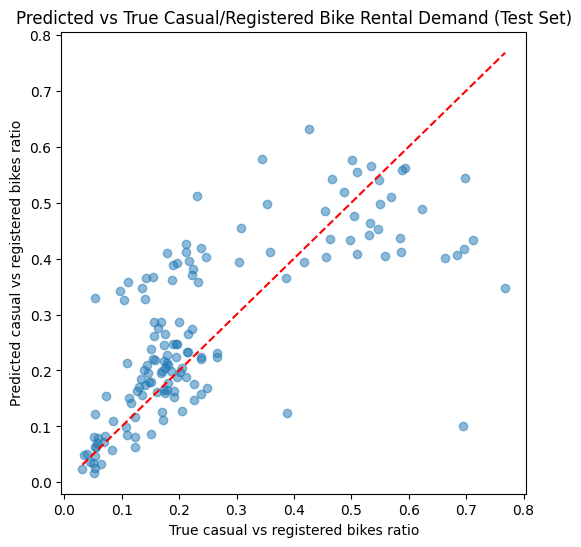

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--",
    color="red"
)
plt.xlabel("True casual vs registered bikes ratio")
plt.ylabel("Predicted casual vs registered bikes ratio")
plt.title("Predicted vs True Casual/Registered Bike Rental Demand (Test Set)")
plt.show()

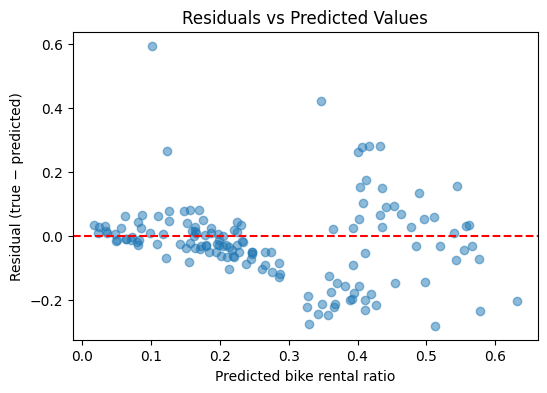

In [ ]:
residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted bike rental ratio")
plt.ylabel("Residual (true − predicted)")
plt.title("Residuals vs Predicted Values")
plt.show()